# prfpy for nCSF fitting. Example notebook

In [72]:
# Assuming you have already installed prfpy_csenf

%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
opj = os.path.join
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from prfpy_csenf.model import CSenFModel
from prfpy_csenf.stimulus import CSenFStimulus
from prfpy_csenf.fit import CSenFFitter
from prfpy_csenf.rf import * 
from prfpy_csenf.csenf_plot_functions import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load stimulus settings 

In [2]:
# Make some example experiment parameters.
# These are the ones used in (*citation*)
# 6 SF levels
SF_levels = [ 0.5,  1.,   3.,   6.,  12.,  18. ] 
# 14 contrasts levels. Log spaced between 0.25 and 80
# [0.25, 0.39, 0.607, 0.946, 1.475, 2.299, 3.582, 5.583, 8.701, 13.56, 21.134, 32.937, 51.332, 80.]
contrast_levels = np.logspace(np.log10(0.25), np.log10(80), 14)

# stimulus sequence
# blank -> random SF descending contrast -> random SF ascending contrast -> blank ... repeat
# i.e., 
# SF_order = [0, 3, 18, 0, 1, 6, 0, 0.5, 12, 0, 6, 1, 0, 12, 3, 0,  18, 0.5, 0]
# -> also include blanks
# blank_length = 10 

# We also miss out some contrast levels for some frequencies, to sample parameter space more efficiently...
# See paper for details
# Load them in here
# Sequence of SFs and contrast levels (214 steps)
sfs_seq = np.load('eg_sfs_seq.npy')
con_seq = np.load('eg_con_seq.npy')
# con_seq

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


#### Create a stimulus object

In [3]:
# Following the prfpy structure, we can create a stimulus object
# This will put all the stimuli information in one place
# requires: 
# > the sequence of SFs presented (i.e., 1 per TR, blanks represented with 0) 
# > the sequence of contrasts presented ("")
# > TR

# sfs_seq = dag_rescale_bw(np.random.rand(214), 0, 18) 
# con_seq = dag_rescale_bw(np.random.rand(214), 0, 80) 
# con_seq
# Assumes discrete contrast + SF levels
csenf_stim = CSenFStimulus(
    SF_seq  = sfs_seq, # np array, 1D 
    CON_seq = con_seq, # np array, 1D 
    TR      = 1.5,
    )


Number of timepoints: 214
Number of unique SF levels: 6, [ 0.5  1.   3.   6.  12.  18. ]
Number of unique CON levels: 14, [ 0.25   0.39   0.607  0.946  1.475  2.299  3.582  5.583  8.701 13.56
 21.134 32.937 51.332 80.   ]


/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/stimulus.py:252: RuntimeWarning: divide by zero encountered in log10
  self.log_SF_seq = np.log10(self.SF_seq)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/stimulus.py:253: RuntimeWarning: divide by zero encountered in true_divide
  self.CON_S_seq  = 100/self.CON_seq # fix divide by zero


In [5]:
# Now we can make a prfpy_model object. 
csenf_model = CSenFModel(
    stimulus = csenf_stim,
    # Leaving the rest as default
)


#### Create an example model
Now we can create an example instance of a model. We will use the parameters from chung & legge

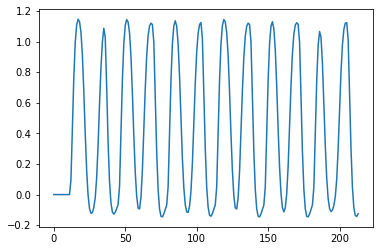

In [11]:
# Now we can some example nCSF models
# For the first entry CSF parameters are taken from the Chung & Legge paper. 
# Everything else is picked pretty randomly
# To really get to grips on how changing model parameters works try out the 'csenf_widget' notebook

eg_params = {
    #                                
    'width_r'           : np.array([   1.28,   1.00,   1.00,   1.00,]), # [CSF parameters]    
    'SFp'               : np.array([   2.50,   2.00,   4.00,   2.00,]), # 
    'CSp'               : np.array([ 166.00, 100.00, 100.00, 100.00,]), # 
    'width_l'           : np.array([   0.68,   0.68,   0.68,   0.68,]), # 
    'crf_exp'           : np.array([   1.50,   1.50,   2.50,   3.00,]), # [CRF parameter]
    'amp_1'             : np.array([   1.00,   1.00,   1.00,   1.00,]), # [fMRI parameters]
    'bold_baseline'     : np.array([   0.00,   0.00,   0.00,   0.00,]), # 
    'hrf_1'             : np.array([   1.00,   1.00,   1.00,   1.00,]), # 
    'hrf_2'             : np.array([   0.00,   0.00,   0.00,   0.00,]), # 
    }
# Now we can use these with our stimulus info to generate a time series!
eg_ts1 = csenf_model.return_prediction(
    width_r     = eg_params['width_r'],
    SFp         = eg_params['SFp'],
    CSp         = eg_params['CSp'],
    width_l     = eg_params['width_l'],                          
    crf_exp     = eg_params['crf_exp'],
    beta        = eg_params['amp_1'],
    baseline    = eg_params['bold_baseline'],
    hrf_1       = eg_params['hrf_1'],
    hrf_2       = eg_params['hrf_2'],
)
plt.plot(eg_ts1[3,:])


# eg_ts2 = csenf_model2.return_prediction(
#     width_r     = eg_params['width_r'],
#     SFp         = eg_params['SFp'],
#     CSp         = eg_params['CSp'],
#     width_l     = eg_params['width_l'],                          
#     crf_exp     = eg_params['crf_exp'],
#     beta        = eg_params['amp_1'],
#     baseline    = eg_params['bold_baseline'],
#     hrf_1       = eg_params['hrf_1'],
#     hrf_2       = eg_params['hrf_2'],
# )
# plt.plot(eg_ts2[1,:])
# Lets show you what this looks like

In [ ]:
eg_ts = nCSF_response(
    SF_seq = csenf_stim.SF_seq,
    CON_seq = csenf_stim.CON_seq,
    width_r     = eg_params['width_r'],
    SFp         = eg_params['SFp'],
    CSp         = eg_params['CSp'],
    width_l     = eg_params['width_l'],                          
    crf_exp     = eg_params['crf_exp'],   
    edge_type='CRF'      

)
plt.plot(eg_ts.T)
# eg_ts.shape

#### Making everything a bit prettier
I've put together some functions to make it easier to visualize and plot your nCSF models

/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/rf.py:275: RuntimeWarning: divide by zero encountered in log10
  log_SFp = np.log10(SFp)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/rf.py:217: RuntimeWarning: divide by zero encountered in true_divide
  
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/model.py:1039: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if current_hrf != 'direct':
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/csenf_plot_functions.py:592: RuntimeWarning: divide by zero encountered in true_divide
  self.prfpy_model.stimulus.SF_seq, 100/self.prfpy_model.stimulus.CON_seq, color='r', alpha=0.8
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/rf.py:275: RuntimeWarning: divide by zero encountered in log10
  log_SFp = np.log10(S

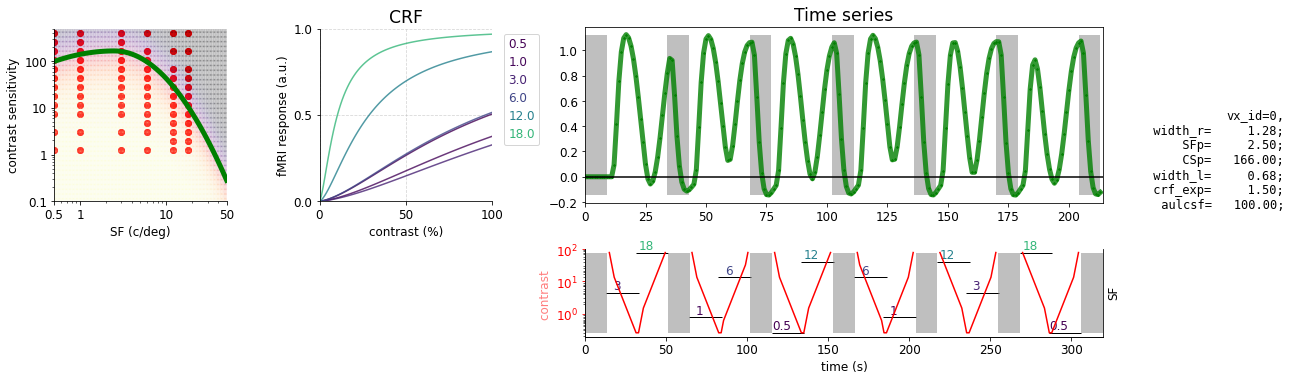

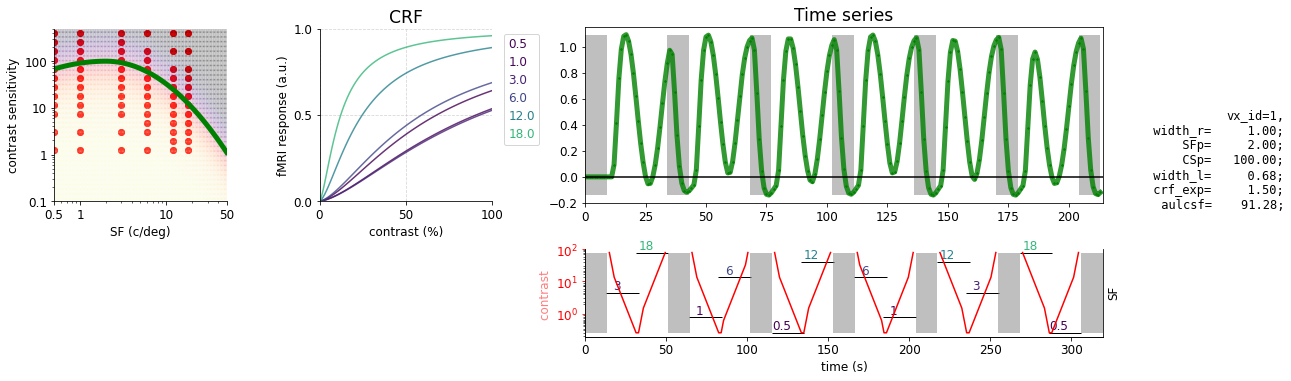

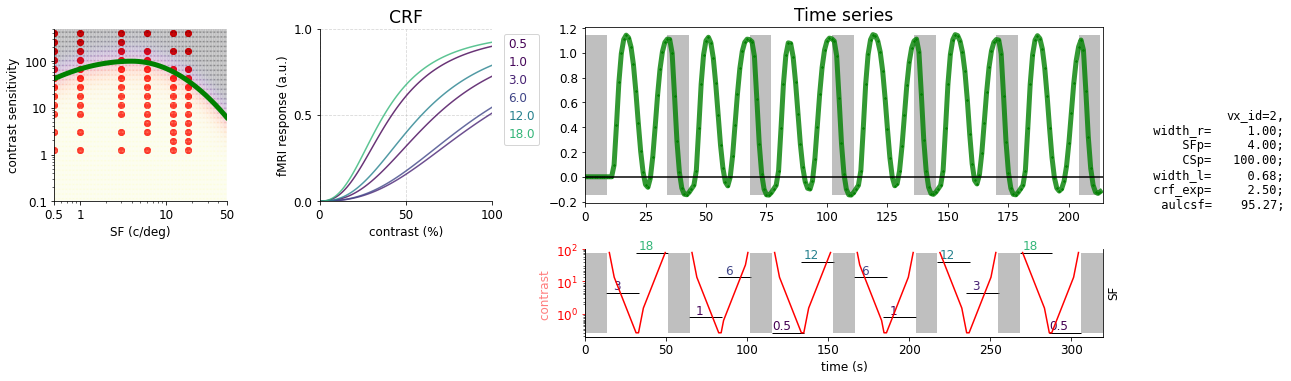

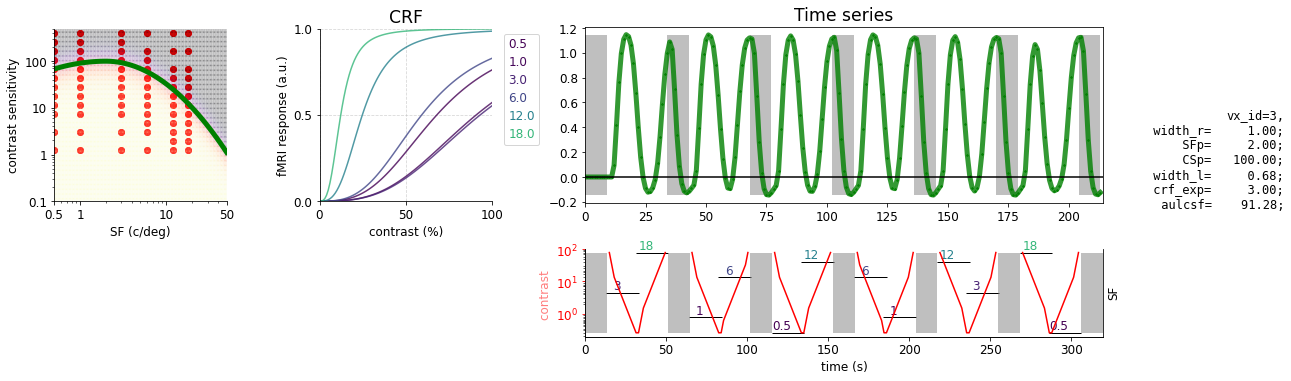

In [68]:
from prfpy_csenf.csenf_plot_functions import *

csenf_plot = CSenFPlotter(
    eg_params,
    prfpy_model=csenf_model, # Include the model so we can generate predictions
    )
# Lets look at the first example model
for i in range(4):
    csenf_plot.csf_ts_plot(idx=i)


From left to right top to bottom:

[1] CSF curve (spatial freq on x axis, log spaced). The green line shows the shape of the traditional "CSF" curve. The colormap below includes the slope component. Showing how the activity changes smoothly from lower to higher contrasts. The little red dots indicate the data points we sample (i.e. what is presented to the subject)

[2] CRF curves. As we go from low to high contrast, the responses change. The slope of these responses is determined by the parameter "crf_exp" aka the "crf_slope". The "C50" or semisaturation point (where the response=50) is determined by our CSF function (see [1]). So that means the crf curve will differ for different SFs. We show several SFs here

[3] The response of the model at each time point is determined by the nCSF value at the specific contrast and SF level (i.e., the entry at )

In [73]:
from ncsf_python.notebook_to_load import *

using default hrf


/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/rf.py:379: RuntimeWarning: divide by zero encountered in log10
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/rf.py:409: RuntimeWarning: divide by zero encountered in true_divide
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/rf.py:410: RuntimeWarning: divide by zero encountered in true_divide
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/rf.py:410: RuntimeWarning: overflow encountered in true_divide
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/rf.py:412: RuntimeWarning: overflow encountered in power
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/rf.py:412: RuntimeWarning: invalid value encountered in true_divide
/data1/projects/dumoulinlab/Lab_members/Marcus/projects/csf/code/ncsf_python/ncsf_python/utils.py:73: RuntimeWarning: divide by zer

using default hrf


/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:313: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_SFp'] = np.log10(self.params_dd['SFp'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:314: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_CSp'] = np.log10(self.params_dd['CSp'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:315: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_crf_exp'] = np.log10(self.params_dd['crf_exp'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:317: RuntimeWarning: divide by zero encountered in true_divide
  10**(np.sqrt(self.params_dd['log10_CSp']/(self.params_dd['width_r']**2)) + \
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_p

using default hrf


/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:313: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_SFp'] = np.log10(self.params_dd['SFp'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:314: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_CSp'] = np.log10(self.params_dd['CSp'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:315: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_crf_exp'] = np.log10(self.params_dd['crf_exp'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:317: RuntimeWarning: divide by zero encountered in true_divide
  10**(np.sqrt(self.params_dd['log10_CSp']/(self.params_dd['width_r']**2)) + \
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_p

using default hrf


/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:313: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_SFp'] = np.log10(self.params_dd['SFp'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:314: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_CSp'] = np.log10(self.params_dd['CSp'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:315: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_crf_exp'] = np.log10(self.params_dd['crf_exp'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:317: RuntimeWarning: divide by zero encountered in true_divide
  10**(np.sqrt(self.params_dd['log10_CSp']/(self.params_dd['width_r']**2)) + \
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_p

using default hrf


/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:313: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_SFp'] = np.log10(self.params_dd['SFp'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:314: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_CSp'] = np.log10(self.params_dd['CSp'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:315: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_crf_exp'] = np.log10(self.params_dd['crf_exp'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_prf_utils/prfpy_functions.py:317: RuntimeWarning: divide by zero encountered in true_divide
  10**(np.sqrt(self.params_dd['log10_CSp']/(self.params_dd['width_r']**2)) + \
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/dag_prf_utils/dag_p

In [78]:
# Now we can make a prfpy_model object. 
csenf_model = CSenFModel(
    stimulus = csenf_stim,
    # Leaving the rest as default
)

a = CSenFPlotter(
    pars_obj[sub].prf_obj['csf'].prf_params_np, 
    real_ts = real_ts_csf[sub],
    # fixed_hrf=True,
    prfpy_model=csenf_model, 
    )

prf_params.shape[-1]=8
hrf=default, rsq=params[:,7]


/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/csenf_plot_functions.py:177: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_SFp'] = np.log10(self.params_dd['SFp'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/csenf_plot_functions.py:178: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_CSp'] = np.log10(self.params_dd['CSp'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/csenf_plot_functions.py:179: RuntimeWarning: divide by zero encountered in log10
  self.params_dd['log10_crf_exp'] = np.log10(self.params_dd['crf_exp'])
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/csenf_plot_functions.py:41: RuntimeWarning: divide by zero encountered in log10
  log10_CSp = np.log10(CSp)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/csenf_plot_functions.py:42: RuntimeWarning: divid

0.4680149986205223


/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/rf.py:275: RuntimeWarning: divide by zero encountered in log10
  log_SFp = np.log10(SFp)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/rf.py:217: RuntimeWarning: divide by zero encountered in true_divide
  
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/model.py:1039: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if current_hrf != 'direct':
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_csenf/prfpy_csenf/csenf_plot_functions.py:593: RuntimeWarning: divide by zero encountered in true_divide
  self.prfpy_model.stimulus.SF_seq, 100/self.prfpy_model.stimulus.CON_seq, color='r', alpha=0.8


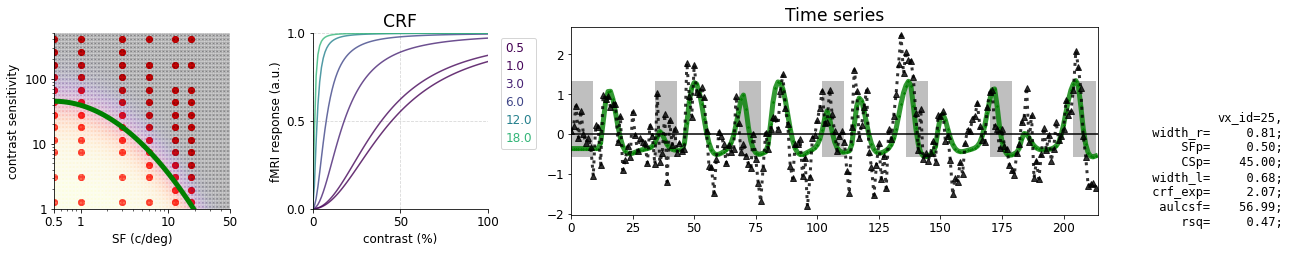

In [91]:
a.csf_ts_plot(25, do_stim_info=False) # do_dm_space=True)

In [ ]:
b

#### Generate an example nCSF time series

In [ ]:
# Now we can make an example nCSF model, and generate some time series
# Lets set the nCSF parameters to be the same as a standard CSF (see Chung & Legge 2016)
# We will set the CRF parameters to be 1.8 
eg_csf_params = {
    'width_r' : 

}
# Store the indices of the parameters in the parameter vector
csf_param_idx = {
    'width_r'   : 0,
    'SFp'       : 1,
    'CSp'      : 2,
    'width_l'   : 3,
    'crf_exp'   : 4,
    'beta'      : 5,
    'baseline'  : 6,
    'hrf_1'     : 7,
    'hrf_2'     : 8,
    'rsq'       : 9,
    }

# PRFPY stimulus
csenf_stim = CSenFStimulus(
    SF_seq  = sfs_seq,
    CON_seq = con_seq,
    TR      = 1.5,
    )

csenf_model = CSenFModel(stimulus = csenf_stim)

# Set the ground truth parameters

In [ ]:
# Use same ground truth (GT) parameters as defined by carlien
# [1] Dictionary of CSenF parameters
csenf_params = {
    'width_r'   : 1.3,
    'SFp'       : 2,
    'CSp'      : 150,
    'width_l'   : 0.448,
    'crf_exp'   : 1.5,
    'beta'      : 1.0,
    'baseline'  : 0.0,
    'hrf_1'     : 1.0,
    'hrf_2'     : 0.0,
    }

# [1] Setup bounds:
bounds = {
    'width_r'   : [0,1.5], # [0,5],
    'SFp'       : [0, 6], # [0, 18]
    'CSp'      : [0, 200], 
    'width_l'   : [0.448, 0.448],
    'crf_exp'   : [0, 10], 
    'beta'      : [0, 1000],
    'baseline'  : [-5,5], 
    'hrf_1'     : [1, 1],
    'hrf_2'     : [0,0],
    # THE FOLLOWING NOT USED FOR FITTING, BUT FOR PLOTTING
    'sfmax'         : [0, 50], 
    'rsq'           : [0, 1],
    'aulcsf'        : [0, 1],
    'ncsf_volume'   : [0, 1],
    #
}



In [ ]:
# Function which takes the dictionary of parameters and returns the extra useful info
def get_GT_info(GT_params):
    GT_info = {}
    # Calculate derived parameters for GT csf models
    # -> functions for calculating derived parameters
    # Calculate log10 versions of parameters
    log10_SFp   = np.log10(GT_params['SFp'])
    log10_CSp  = np.log10(GT_params['CSp'])

    # Calculate CSF curves + matrix 
    csf_mat, csf_curve = csenf_exponential(
        log_SF_grid = csenf_stim.log_SF_grid, 
        CON_S_grid  = csenf_stim.CON_S_grid,
        width_r     = GT_params['width_r'], 
        SFp         = GT_params['SFp'], 
        CSp        = GT_params['CSp'], 
        width_l     = GT_params['width_l'], 
        crf_exp     = GT_params['crf_exp'],
        return_curve=True,
        )    
    
    # Full RF (same as above, but we sample more densly, for plotting) i.e., not in DM space
    sf_grid = np.logspace(np.log10(csenf_stim.SFs[0]),np.log10(csenf_stim.SFs[-1]), 50)
    con_grid = np.logspace(np.log10(csenf_stim.CON_Ss[-1]),np.log10(csenf_stim.CON_Ss[0]), 50)
    # sf_grid = np.logspace(np.log10(.25),np.log10(20), 50)
    # con_grid = np.logspace(np.log10(.1),np.log10(500), 50)    
    sf_grid, con_grid = np.meshgrid(sf_grid,con_grid)
    full_csf = csenf_exponential(
        log_SF_grid = np.log10(sf_grid), 
        CON_S_grid = con_grid, 
        width_r     = GT_params['width_r'], 
        SFp         = GT_params['SFp'], 
        CSp        = GT_params['CSp'], 
        width_l     = GT_params['width_l'], 
        crf_exp     = GT_params['crf_exp'],
        return_curve = False)
    full_csf_info = {
        'sf_grid'   : sf_grid,
        'con_grid'  : con_grid,
        'full_csf'  : full_csf,
    }


    # Log CSF curve
    logcsf_curve = np.log10(csf_curve)    
    logcsf_curve[logcsf_curve<0 ] = 0

    # Calculate AULCSF (area under log CSF)
    aulcsf = calculate_aulcsf(
        log_SF_grid = csenf_stim.log_SF_grid, 
        CON_S_grid  = csenf_stim.CON_S_grid,
        width_r     = GT_params['width_r'], 
        SFp         = GT_params['SFp'], 
        CSp        = GT_params['CSp'], 
        width_l     = GT_params['width_l'], 
        crf_exp     = GT_params['crf_exp'],
        )    

    # Calculate nCSF_volume (like aulcsf, but takes into account the CRF)
    ncsf_volume = calculate_nCSF_volume(
        log_SF_grid = csenf_stim.log_SF_grid,
        CON_S_grid  = csenf_stim.CON_S_grid,
        width_r     = GT_params['width_r'],
        SFp         = GT_params['SFp'],
        CSp        = GT_params['CSp'],
        width_l     = GT_params['width_l'],
        crf_exp     = GT_params['crf_exp'],
        )

    # Calculate sfmax
    sfmax = calculate_sfmax(
        width_r     = GT_params['width_r'], 
        SFp         = GT_params['SFp'], 
        CSp        = GT_params['CSp'], 
        )

    # Calculate the time series for the GT parameters
    ts = csenf_model.return_prediction(**GT_params)
        

    # Put it all together in a dict
    GT_info = {
        **GT_params,
        'log10_SFp'     : log10_SFp,
        'log10_CSp'    : log10_CSp,
        'csf_mat'       : csf_mat,
        'csf_curve'     : csf_curve,
        'logcsf_curve'  : logcsf_curve,
        'aulcsf'        : aulcsf,
        'ncsf_volume'   : ncsf_volume,    
        'sfmax'         : sfmax,
        'ts'            : ts,
        'full_csf_info' : full_csf_info,
    }
    return GT_info

In [ ]:
import ipywidgets as widgets
from IPython.display import display, HTML
from dag_prf_utils.plot_functions import *

In [ ]:
def csf_prf_widget(w_params):
    # Load the specified info 
    w_params_names = ['width_r',   'SFp',       'CSp',      'width_l',   'crf_exp',   'beta',      'baseline',  'hrf_1',     'hrf_2', ]
    GT_params = {}
    for i,p in enumerate(w_params_names):
        GT_params[p] = np.array([w_params[i]])
    GT_info = get_GT_info(GT_params)
    # PLOTTING
    
    # Set up figure
    fig, ax = plt.subplots(
    2, 3,
    gridspec_kw={'width_ratios': [2,1,6], 'height_ratios':[3,1.5]},
    figsize=(20,9),           # figsize=(15,9),           
    )   
    # Turn off unwanted axes
    ax[1][0].axis('off')
    ax[1][1].axis('off')   


    # *********** ax 0,0: CSF curve + with imshow to display CRF curve ***********
    # ax.set_title(f'CSF curve')    
    ax[0][0].set_xlabel('SF (c/deg)')
    ax[0][0].set_ylabel('100/Contrast')
    ax[0][0].set_xscale('log')
    ax[0][0].set_yscale('log')

    # Scatter the points sampled
    ax[0][0].scatter(
        csenf_stim.SF_seq, 100/csenf_stim.CON_seq, color='r', alpha=0.8
    )
    # Plot the CSF curve
    ax[0][0].plot(
        csenf_stim.SFs, 
        GT_info['csf_curve'], 
        color='g', linewidth=5)

    # Plot the full CSF 
    scat_col = ax[0][0].scatter(
        GT_info['full_csf_info']['sf_grid'].ravel(),
        GT_info['full_csf_info']['con_grid'].ravel(),
        c=GT_info['full_csf_info']['full_csf'].ravel(),
        vmin=0, vmax=1,
        alpha=.1,
        cmap='magma'
    )        
    # Put a grid on the axis (only the major ones)
    ax[0][0].grid(which='both', axis='both', linestyle='--', alpha=0.5)
    # Make the axis square
    ax[0][0].set_aspect('equal', 'box') 
    ax[0][0].set_xticks([.1, 1,10,100])
    ax[0][0].set_yticks([.1, 1,10,100, 1000])
    ax[0][0].set_xlim([0.25, 50]) # [0.1, 100])
    ax[0][0].set_ylim([1, 500]) # [0.1, 1000])
    ax[0][0].legend()
    # ***********************************************************************


    # *********** ax 0,1: CSF in DM space ***********
    # RF - in DM space:
    ax[0][1].imshow(GT_info['csf_mat'][0,:,:], vmin=0, vmax=1, cmap='magma')#, alpha=.5)        
    # Add grids to show the "matrix" aspect
    ax[0][1].set_xticks(np.arange(len(csenf_stim.SFs))-.5)
    # ax[0][1].set_xticklabels(csenf_stim.SFs)
    ax[0][1].set_xticklabels([])
    ax[0][1].set_yticks(np.arange(len(csenf_stim.CON_Ss))-.5)
    # ax[0][1].set_yticklabels(np.round(csenf_stim.CON_Ss,2))
    ax[0][1].set_yticklabels([])
    # Grids, thick red lines
    ax[0][1].grid(which='major', axis='both', linestyle='-', color='r', linewidth=2)
    ax[0][1].set_title('CSF-DM space')
    # ***********************************************************************


    # *********** ax 0,2: Time series ***********
    ax[0][2].plot(GT_info['ts'].T, color='g', linewidth=5)
    ax[0][2].set_xlim(0, GT_info['ts'].shape[-1])
    ax[0][2].set_title('Time series')
    ax[0][2].plot((0,GT_info['ts'].shape[-1]), (0,0), 'k')   
    # Find the time for 0 stimulation, add grey patches
    id_no_stim = csenf_stim.SF_seq==0.0
    x = np.arange(len(id_no_stim))
    y1 = np.ones_like(x)*np.nanmin(GT_info['ts'])
    y2 = np.ones_like(x)*np.nanmax(GT_info['ts'])
    ax[0][2].fill_between(x, y1, y2, where=id_no_stim, facecolor='grey', alpha=0.5)    
    # ***********************************************************************


    # *********** ax 1,2: Stimulus info ***********
    # -> SF sequence
    SF_seq = csenf_stim.SF_seq.copy()
    SF_seq[SF_seq==0] = np.nan

    SF_ax = ax[1][2]
    SF_ax.set_yscale('log')
    SF_ax.plot(SF_seq, 'k')                
    SF_ax.set_xlabel('time (s)')
    SF_ax.set_ylabel('log SF', color='black')

    # -> 100/Contrast seq
    con_s_seq = csenf_stim.CON_S_seq.copy()
    con_s_seq[con_s_seq==np.inf] = np.nan
    con_s_ax = SF_ax.twinx()                        
    con_s_ax.plot(con_s_seq, 'r')
    # set ylabel to red, also yticks
    con_s_ax.set_ylabel('100/Contrast', color='red')
    con_s_ax.tick_params(axis='y', colors='red')

    # Add grey patches corresponding to the nan values in con_s_seq
    x = np.arange(len(con_s_seq))
    nan_idx = np.argwhere(np.isnan(con_s_seq))
    y1 = np.ones_like(x)*np.nanmin(con_s_seq)
    y2 = np.ones_like(x)*np.nanmax(con_s_seq)
    con_s_ax.fill_between(x, y1, y2, where=np.isnan(con_s_seq), facecolor='grey', alpha=0.5)
    # set xlim
    con_s_ax.set_xlim(0, len(con_s_seq))    
    # put x axis for con_s_ax and SF_ax at the top of the axis
    SF_ax.xaxis.tick_top()
    # ***********************************************************************


    # *********** Bottom left Text ***********
    gt_txt = f'Parameters \n' + \
        f'width_r={GT_info["width_r"][0]:>8.2f}, \n' + \
        f'SFp={GT_info["SFp"][0]:>8.2f}, \n' + \
        f'CSp={GT_info["CSp"][0]:>8.2f}, \n' + \
        f'width_l={GT_info["width_l"][0]:>8.2f}, \n' + \
        f'crf_exp={GT_info["crf_exp"][0]:>8.2f}, \n' + \
        f'sfmax={GT_info["sfmax"][0]:>8.2f}, \n' + \
        f'aulcsf={GT_info["aulcsf"][0]:>8.2f}, \n' + \
        f'ncsf_volume={GT_info["ncsf_volume"][0]:>8.2f}, \n' 

    fig.text(.25, 0.20, gt_txt, transform=fig.transFigure, fontsize=20, va='center', ha='right', family='monospace',)
    # ***********************************************************************

    fig.set_tight_layout(True)
    dag_update_fig_fontsize(fig, 15)    
    return

    


# csf_prf_widget(list(w_params.values()))
# csenf_stim.CON_S_seq

In [ ]:
# ***************** WIDGETS PRF MODEL 1 *****************
# Make a widget with editable parameters for 1 model only
# [1] Dictionary of CSenF parameters
w_params = {
    'width_r'   : 1.3,
    'SFp'       : 2,
    'CSp'      : 150,
    'width_l'   : 0.448,
    'crf_exp'   : 1.5,
    'beta'      : 1.0,
    'baseline'  : 0.0,
    'hrf_1'     : 1.0,
    'hrf_2'     : 0.0,
    }

# [1] Setup bounds:
w_bounds = {
    'width_r'   : [0,1.5], # [0,5],
    'SFp'       : [0, 6], # [0, 18]
    'CSp'      : [0, 200], 
    'width_l'   : [0.448, 0.448],
    'crf_exp'   : [0, 10], 
    'beta'      : [0, 1000],
    'baseline'  : [-5,5], 
    'hrf_1'     : [1, 1],
    'hrf_2'     : [0,0],
}




widg_controls=[]
for key in w_params.keys():    
    sl=widgets.BoundedFloatText(
        description=key,
        min=w_bounds[key][0], 
        max=w_bounds[key][1], 
        # step=w_param_min_max_step[i,2], 
        value=w_params[key],
        orientation = "vertical",
        continuous_update=False)    
    widg_controls.append(sl)
    
widg_Dict = {} 
for c in widg_controls:
    widg_Dict[c.description] = c  

left_widg = widgets.VBox(tuple([widg_controls[i] for i in range(5)]))
right_widg = widgets.VBox([widg_controls[i] for i in range(5,9)])
widg_uif = widgets.HBox([left_widg, right_widg])

def widg_update_N(**xvalor):
    xvalor=[]
    for i in range(len(widg_controls)):
        xvalor.append(widg_controls[i].value)
    
    csf_prf_widget(xvalor)

widg_outf = widgets.interactive_output(widg_update_N,widg_Dict)
display(widg_uif, widg_outf)

In [ ]:
def csf_prf_widget_MULTI(GT_params):
    # Load the specified info 

    # GT_params = {}
    # for p in param_dict.keys():
    #     GT_params[p] = np.array(list(param_dict[p]))[...,np.newaxis]
    # print(GT_params)
    GT_info = get_GT_info(GT_params)
    n_gt = len(GT_params['width_r']) # Number of ground truth models
    
    # Set up figure
    nrows = 1 + n_gt
    ncols = 4#3
    width_ratios = [2,1,1,6]
    height_ratios = [*[2]*n_gt,1] # 2 for each GT model, 1 for stim info
    fig_height = 2 + 4*n_gt 
    fig_size = (21,fig_height) # height depends on number of GT models

    fig, ax = plt.subplots(
    nrows, ncols,
    gridspec_kw={'width_ratios': width_ratios, 'height_ratios':height_ratios},
    figsize=fig_size,
    )   
    # Turn off unwanted axes
    ax[-1][0].axis('off')
    ax[-1][1].axis('off')   
    ax[-1][2].axis('off') # new
    
    # *********** ax -1,2: Stimulus info ***********
    # Add the stimulus plots (independent of number of GT models)
    # -> SF sequence
    SF_seq = csenf_stim.SF_seq.copy()
    SF_seq[SF_seq==0] = np.nan

    SF_ax = ax[-1][2]
    SF_ax.set_yscale('log')
    SF_ax.plot(SF_seq, '*k')                
    SF_ax.set_xlabel('time (s)')
    SF_ax.set_ylabel('log SF', color='black')

    # -> 100/Contrast seq
    con_s_seq = csenf_stim.CON_S_seq.copy()
    con_s_seq[con_s_seq==np.inf] = np.nan
    con_s_ax = SF_ax.twinx()                        
    con_s_ax.plot(con_s_seq, 'r')
    # set ylabel to red, also yticks
    con_s_ax.set_ylabel('100/Contrast', color='red')
    con_s_ax.tick_params(axis='y', colors='red')

    # Add grey patches corresponding to the nan values in con_s_seq
    x = np.arange(len(con_s_seq))
    y1 = np.ones_like(x)*np.nanmin(con_s_seq)
    y2 = np.ones_like(x)*np.nanmax(con_s_seq)
    con_s_ax.fill_between(x, y1, y2, where=np.isnan(con_s_seq), facecolor='grey', alpha=0.5)
    # set xlim
    con_s_ax.set_xlim(0, len(con_s_seq))    
    # put x axis for con_s_ax and SF_ax at the top of the axis
    # SF_ax.xaxis.tick_top()
    # ***********************************************************************

    # Loop over the number of GT models
    for i in range(n_gt):
        
        # *********** ax 0,0: CSF curve + with imshow to display CRF curve ***********
        # ax.set_title(f'CSF curve')    
        ax[i][0].set_xlabel('SF (c/deg)')
        ax[i][0].set_ylabel('100/Contrast')
        ax[i][0].set_xscale('log')
        ax[i][0].set_yscale('log')

        # Scatter the points sampled
        ax[i][0].scatter(
            csenf_stim.SF_seq, 100/csenf_stim.CON_seq, color='r', alpha=0.8
        )
        # Plot the CSF curve
        ax[i][0].plot(
            csenf_stim.SFs, 
            GT_info['csf_curve'][:,i], 
            color='g', linewidth=5)

        # Plot the full CSF 
        ax[i][0].scatter(
            GT_info['full_csf_info']['sf_grid'].ravel(),
            GT_info['full_csf_info']['con_grid'].ravel(),
            c=GT_info['full_csf_info']['full_csf'][i,:,:].ravel(),
            vmin=0, vmax=1,
            alpha=.3,
            cmap='magma'
        )        
        # Put a grid on the axis (only the major ones)
        ax[i][0].grid(which='both', axis='both', linestyle='--', alpha=0.5)
        # Make the axis square
        ax[i][0].set_aspect('equal', 'box') 
        ax[i][0].set_xticks([.1, 1,10,100])
        ax[i][0].set_yticks([.1, 1,10,100, 1000])
        ax[i][0].set_xlim([0.25, 50]) # [0.1, 100])
        ax[i][0].set_ylim([1, 500]) # [0.1, 1000])
        ax[i][0].legend()
        # ***********************************************************************
        

        # *********** ax 0,1: CSF in DM space ***********
        # RF - in DM space:
        ax[i][1].imshow(GT_info['csf_mat'][i,:,:], vmin=0, vmax=1, cmap='magma')#, alpha=.5)        
        # Add grids to show the "matrix" aspect
        ax[i][1].set_xticks(np.arange(len(csenf_stim.SFs))-.5)
        # ax[i][1].set_xticklabels(csenf_stim.SFs)
        ax[i][1].set_xticklabels([])
        ax[i][1].set_yticks(np.arange(len(csenf_stim.CON_Ss))-.5)
        # ax[i][1].set_yticklabels(np.round(csenf_stim.CON_Ss,2))
        ax[i][1].set_yticklabels([])
        # Grids, thick red lines
        ax[i][1].grid(which='major', axis='both', linestyle='-', color='r', linewidth=2)
        ax[i][1].set_title('CSF-DM space')
        # ***********************************************************************

        # *********** ax 0,2: CRF ***********
        # Plot recovered contrast response functions
        contrast_pc = np.linspace(0, 100, 100)    
        ax[i][2].set_xlabel('contrast (%)')
        ax[i][2].set_ylabel('fMRI Response')

        # Plot ground truth -> thick black line
        crf_resp = calculate_crf_curve(crf_exp=GT_dict['crf_curve'][i_gt], C=contrast_pc)
        ax.plot(
            contrast_pc, 
            crf_resp, 
            color='k', linewidth=5, label='Ground truth')

        # Put a grid on the axis (only the major ones)
        ax.grid(which='both', axis='both', linestyle='--', alpha=0.5)
        # Make the axis square
        # ax.set_aspect('equal', 'box') 
        ax.set_xticks([0, 50,100])
        ax.set_yticks([0, 0.5, 1.0])
        ax.set_xlim([0, 100])
        ax.set_ylim([0, 1])
        ax.legend()       
        # *********************************************************************** 
        
        # *********** ax 0,-1: Time series ***********
        ax[i][-1].plot(GT_info['ts'][i,:], color='g', linewidth=5)
        ax[i][-1].set_xlim(0, GT_info['ts'].shape[-1])
        ax[i][-1].set_title('Time series')
        ax[i][-1].plot((0,GT_info['ts'].shape[-1]), (0,0), 'k')   
        # Find the time for 0 stimulation, add grey patches
        id_no_stim = csenf_stim.SF_seq==0.0
        x = np.arange(len(id_no_stim))
        y1 = np.ones_like(x)*np.nanmin(GT_info['ts'])
        y2 = np.ones_like(x)*np.nanmax(GT_info['ts'])
        ax[i][-1].fill_between(x, y1, y2, where=id_no_stim, facecolor='grey', alpha=0.5)    
        # ***********************************************************************




        # *********** Bottom left Text ***********
        gt_txt = f'width_r={GT_info["width_r"][i]:>8.2f}, \n' + \
            f'SFp={GT_info["SFp"][i]:>8.2f}, \n' + \
            f'CSp={GT_info["CSp"][i]:>8.2f}, \n' + \
            f'width_l={GT_info["width_l"][i]:>8.2f}, \n' + \
            f'crf_exp={GT_info["crf_exp"][i]:>8.2f}, \n' + \
            f'sfmax={GT_info["sfmax"][i]:>8.2f}, \n' #+ \
            # f'aulcsf={GT_info["aulcsf"][i]:>8.2f}, \n' + \
            # f'ncsf_volume={GT_info["ncsf_volume"][i]:>8.2f}, \n' 
        # Add the text to the right of the time series figure
        # Ax is in axis coordinates, so 0,0 is bottom left, 1,1 is top right
        ax[i][-1

In [ ]:
].text(1.35, 0.20, gt_txt, transform=ax[i][2].transAxes, fontsize=20, va='center', ha='right', family='monospace',)
        # ***********************************************************************

    # fig.set_tight_layout(True)
    dag_update_fig_fontsize(fig, 15)    
    return

    


# csf_prf_widget_MULTI(w_params)
# csenf_stim.CON_S_seq

In [ ]:
# ***************** WIDGETS PRF MODEL MULTI *****************
# Make a widget with editable parameters for MULTIPLE models
# [1] Dictionary of CSenF parameters
w_params = {
    'width_r'   : 1.3,
    'SFp'       : 2,
    'CSp'      : 150,
    'width_l'   : 0.448,
    'crf_exp'   : 1.5,
    'beta'      : 1.0,
    'baseline'  : 0.0,
    'hrf_1'     : 1.0,
    'hrf_2'     : 0.0,
    }




widg_controls=[]

for key in w_params.keys():    
    # Make text monospace
    sl=widgets.Text(
        description=key,
        value=f'{w_params[key]:<8.2f},',
        orientation = "vertical",
        continuous_update=False,
        font_family='monospace',
        )
    widg_controls.append(sl)


widg_Dict = {} 
for c in widg_controls:
    widg_Dict[c.description] = c  


left_widg = widgets.VBox(tuple([widg_controls[i] for i in range(5)]))
right_widg = widgets.VBox([widg_controls[i] for i in range(5,9)])
widg_uif = widgets.HBox([left_widg, right_widg])

def widg_output_to_dict(widg_output):
    w_params_names = ['width_r',   'SFp',       'CSp',      'width_l',   'crf_exp',   'beta',      'baseline',  'hrf_1',     'hrf_2', ]
    # GT_params = {}
    # [1] Find number of models in total, and for each parameter
    n_models = []    
    # print(len(widg_output[0].split(',')))
    # return
    param_dict = {}
    n_models = {}
    for i,p in enumerate(w_params_names):
        # Split widg_output[i] by ',' returning list (not including ',' itself)
        param_vals = widg_output[i].split(',')
        # remove any entry which does not contain a number in the string
        param_vals = [s for s in param_vals if any(c.isdigit() for c in s)]
        # Convert to float
        param_vals = [float(s) for s in param_vals]
        n_models[p] = len(param_vals)
        param_dict[p] = param_vals
    max_n_models = np.max(list(n_models.values()))
    # Loop through each parameter, and if it has less than max_n_models, duplicate the last value
    # until it has max_n_models
    for i,p in enumerate(w_params_names):
        while n_models[p] < max_n_models:
            # Duplicate the last value
            param_dict[p] = np.append(param_dict[p], param_dict[p][-1])
            n_models[p] = len(param_dict[p])

    return param_dict

    
class Widg_Updater():
    def __init__(self):
        self.do_update = True


    def widg_update_N(self, **xvalor):
        if not self.do_update: # make sure we don't loop around and around...
            return
        self.do_update = False

        # *** 
        w_params_names = ['width_r',   'SFp',       'CSp',      'width_l',   'crf_exp',   'beta',      'baseline',  'hrf_1',     'hrf_2', ]
        xvalor=[]
        for i,p in enumerate(w_params_names):
            xvalor.append(widg_controls[i].value)
        param_dict = widg_output_to_dict(xvalor)
        # Before 
        # Use this to update the widget values
        for i,p in enumerate(w_params_names):
            # widg_str is a string of comma separated values, equally spaced, with 2 decimal points 
            widg_str = ','.join([f'{v:<8.2f}' for v in param_dict[p]])
            # print(widg_str)
            widg_controls[i].value = widg_str
        # Sanitize param_dict into GT_params
        GT_params = {}
        for p in param_dict.keys():
            GT_params[p] = np.array(list(param_dict[p]))
        
        csf_prf_widget_MULTI(GT_params)

        self.do_update = True
        return

w_update = Widg_Updater()

widg_outf = widgets.interactive_output(w_update.widg_update_N,widg_Dict)
display(widg_uif, widg_outf)